# Training CiFAR with Keras

This simple example demonstrates how to plug TensorFlow Datasets (TFDS) into a Keras model.


In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt

## Imports and setup
We use `tensorflow` for modeling and `tensorflow_datasets` (TFDS) for convenient dataset loading + metadata. Make sure the notebook kernel points to the environment where TensorFlow is installed.

## Step 1: Create your input pipeline

Start by building an efficient input pipeline using advices from:
* The [Performance tips](https://www.tensorflow.org/datasets/performances) guide
* The [Better performance with the `tf.data` API](https://www.tensorflow.org/guide/data_performance#optimize_performance) guide


### Load a dataset

Load the MNIST dataset with the following arguments:

* `shuffle_files=True`: The MNIST data is only stored in a single file, but for larger datasets with multiple files on disk, it's good practice to shuffle them when training.
* `as_supervised=True`: Returns a tuple `(img, label)` instead of a dictionary `{'image': img, 'label': label}`.

In [3]:
(ods_train, ods_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

2026-01-22 11:26:20.895398: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4
2026-01-22 11:26:20.895421: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 24.00 GB
2026-01-22 11:26:20.895425: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 8.00 GB
2026-01-22 11:26:20.895440: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2026-01-22 11:26:20.895450: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


### Dataset info
`ds_info` includes split sizes, feature shapes, and class labels. We’ll use it later for class names and sanity checks.

### Build a training pipeline

Apply the following transformations:

* `tf.data.Dataset.map`: TFDS provide images of type `tf.uint8`, while the model expects `tf.float32` in the range [0,1]. Therefore, you need to normalize images.
* `tf.data.Dataset.cache` As you fit the dataset in memory, cache it before shuffling for a better performance.<br/>
__Note:__ Random transformations should be applied after caching.
* `tf.data.Dataset.shuffle`: For true randomness, set the shuffle buffer to the full dataset size.<br/>
__Note:__ For large datasets that can't fit in memory, use `buffer_size=1000` if your system allows it.
* `tf.data.Dataset.batch`: Batch elements of the dataset after shuffling to get unique batches at each epoch. You can increase the batch size to speed up training, depending on the amount of GPU memory.
* `tf.data.Dataset.prefetch`: It is good practice to end the pipeline by prefetching [for performance](https://www.tensorflow.org/guide/data_performance#prefetching).

In [4]:
def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., label # type: ignore

ds_train = ods_train.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(512)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

### Why these pipeline steps?
- **Normalize** to scale pixels to $[0,1]$ for stable training.
- **Cache** to avoid repeated disk reads.
- **Shuffle** for better randomness each epoch.
- **Batch** to leverage vectorization on GPU.
- **Prefetch** to overlap data loading with model execution.

## EDA

Look at some sample images. Note the way we get the class names from the ds_info dataset and use an iterator to get data from the training set in one batch.

2026-01-22 11:26:23.532253: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


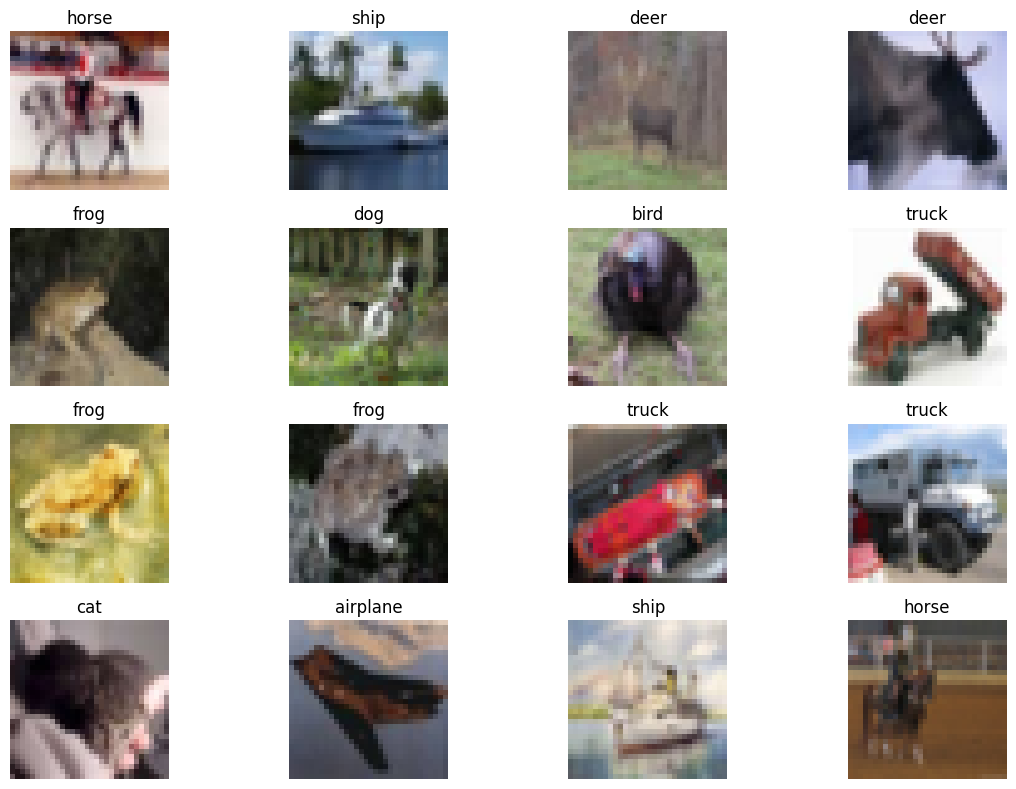

In [5]:
# Display a sample of images from the training set with their labels
class_names = ds_info.features['label'].names

# Take a batch of images and labels
sample_images, sample_labels = next(iter(ods_train.batch(16)))

# Create a plot
plt.figure(figsize=(12, 8))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(sample_images[i].numpy())
    plt.title(class_names[sample_labels[i].numpy()])
    plt.axis('off')
plt.tight_layout()
plt.show()

Use EDA to confirm shapes, class balance, and a few example images before training. This helps catch preprocessing bugs early.

### Build an evaluation pipeline

Your testing pipeline is similar to the training pipeline with small differences:

 * You don't need to call `tf.data.Dataset.shuffle`.
 * Caching is done after batching because batches can be the same between epochs.

In [6]:
ds_test = ods_test.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(128)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

## Step 2: Create and train the model

Plug the TFDS input pipeline into a simple Keras model, compile the model, and train it.

### Baseline model
Start simple: a flattened input and a few dense layers. This sets a reference point before adding regularization or augmentation.

In [ ]:
# Create the Model
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(), # turn the 2D images each into one vector
  tf.keras.layers.Dense(128, activation='leaky_relu'), # a layer with 128 nodes
  tf.keras.layers.Dense(10) # the final layer, one node for each class
])

# Compile the Model
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001), # how exactly does gradient descent take a step and what is the step size
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), # the correct loss function for categorical data
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()], # report accuracy while training
)

# Run the model. Save history for further analysis
history = model.fit(
    ds_train, # the training set
    epochs=30, # number of epochs (full pass through entire training set)
    validation_data=ds_test, # the test set to use while training
)

Define a function to show the training curves using the history from a training session

In [8]:
import matplotlib.pyplot as plt

def show_training_curves(history):
  acc = history.history['sparse_categorical_accuracy']
  val_acc = history.history['val_sparse_categorical_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(len(acc))

  plt.figure(figsize=(12, 4))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.grid(True)

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.grid(True)

  plt.tight_layout()
  plt.show()

Let's see the training run. Validation accuracy is still increasing a bit, so we'll end up training some more

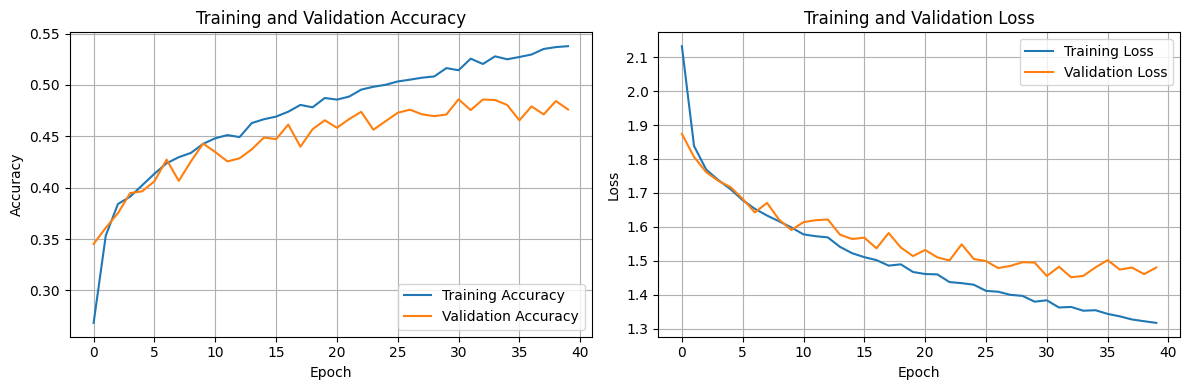

In [10]:
show_training_curves(history)

Because the model seems to be learning still, add 10 more epochs. If you *don't recompile*, then the model starts up where it left off. We do have to manually merge the two histories.

In [11]:
new_history = model.fit(
    ds_train,
    epochs=10,
    validation_data=ds_test,
)

for key in new_history.history:
    history.history[key].extend(new_history.history[key])

Epoch 1/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.3108 - sparse_categorical_accuracy: 0.5405 - val_loss: 1.4487 - val_sparse_categorical_accuracy: 0.4902
Epoch 2/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.3080 - sparse_categorical_accuracy: 0.5381 - val_loss: 1.4852 - val_sparse_categorical_accuracy: 0.4750
Epoch 3/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.3061 - sparse_categorical_accuracy: 0.5407 - val_loss: 1.4466 - val_sparse_categorical_accuracy: 0.4868
Epoch 4/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.2965 - sparse_categorical_accuracy: 0.5457 - val_loss: 1.4608 - val_sparse_categorical_accuracy: 0.4797
Epoch 5/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.2948 - sparse_categorical_accuracy: 0.5438 - val_loss: 1.4413 - val_sparse_categorical_accuracy: 0.4920
Epoch 6/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.2862 - sparse_categorical_accuracy: 0.5504 - val_loss: 1.4517 - val_sparse_categorical_accuracy: 0.4900
Epoch 7/10


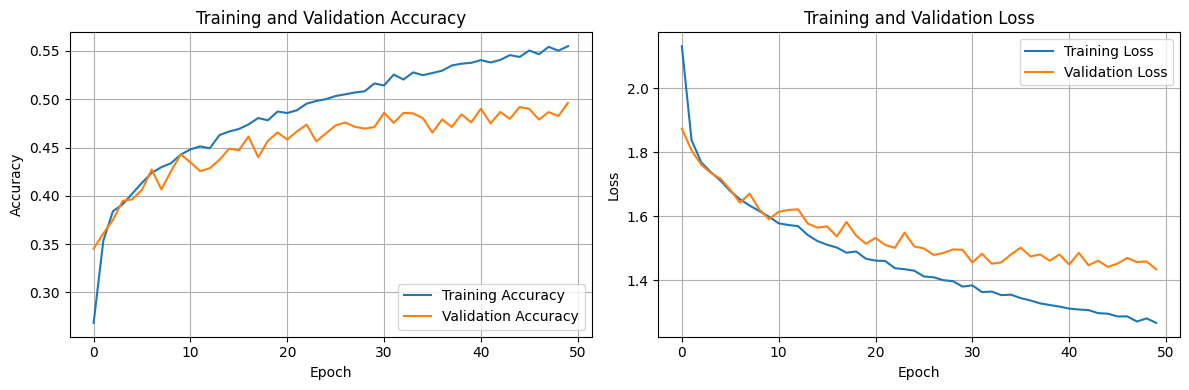

In [12]:
show_training_curves(history)

Let's create a confusion matrix plotting function and run it. Pay attention to the "predictions" logic!!

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def show_confusion_matrix(model, dataset, info):
  # Get true labels from dataset
  true_labels = []
  for images, labels in dataset.unbatch():
      true_labels.append(labels.numpy())
  true_labels = np.array(true_labels)

  # Predict probabilities for the test set
  predictions = model.predict(dataset)

  # Get predicted classes
  predicted_labels = np.argmax(predictions, axis=1) ## VERY IMPORTANT. How you get a class label out of a neural network.

  # Generate the confusion matrix
  cm = confusion_matrix(true_labels, predicted_labels)

  # Get class names from dataset info (assuming cifar10 has 'label' feature with names)
  class_names = info.features['label'].names

  # Plot the confusion matrix
  plt.figure(figsize=(10, 8))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=class_names, yticklabels=class_names)
  plt.xlabel('Predicted Labels')
  plt.ylabel('True Labels')
  plt.title('Confusion Matrix')
  plt.show()

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


2026-01-22 11:27:44.424743: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


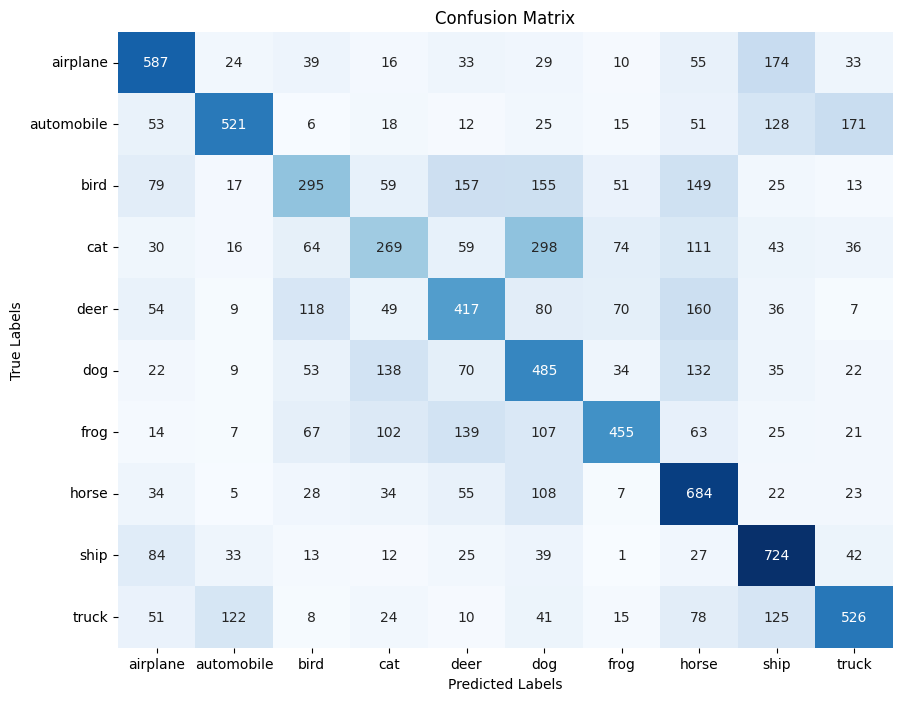

In [16]:
show_confusion_matrix(model, ds_test, ds_info)

## Improve

### Improving the baseline
We gradually add **BatchNorm**, **Dropout**, and **L2 regularization** to improve generalization. We also experiment with a smaller learning rate to stabilize training.

In [19]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(),
  tf.keras.layers.BatchNormalization(), # Changed to BatchNormalization
  tf.keras.layers.Dense(1024, activation='leaky_relu'),
  tf.keras.layers.Dense(512, activation='leaky_relu'),
  tf.keras.layers.Dense(256, activation='leaky_relu'),
  tf.keras.layers.Dense(10)
])

# No need to call .adapt() for BatchNormalization as it learns stats per batch

model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)


history = model.fit(
    ds_train,
    epochs=30,
    validation_data=ds_test,
)

Epoch 1/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 1.8367 - sparse_categorical_accuracy: 0.3881 - val_loss: 1.8279 - val_sparse_categorical_accuracy: 0.3822
Epoch 2/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 1.4636 - sparse_categorical_accuracy: 0.4839 - val_loss: 1.5476 - val_sparse_categorical_accuracy: 0.4722
Epoch 3/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 1.3421 - sparse_categorical_accuracy: 0.5287 - val_loss: 1.4221 - val_sparse_categorical_accuracy: 0.4972
Epoch 4/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 1.2492 - sparse_categorical_accuracy: 0.5612 - val_loss: 1.3950 - val_sparse_categorical_accuracy: 0.5046
Epoch 5/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 1.1464 - sparse_categorical_accuracy: 0.5973 - val_loss: 1.3495 - val_sparse_categorical_accuracy: 0.5295
Epoch 6/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 1.0740 - sparse_categorical_accuracy: 0.6228 - val_loss: 1.3820 - val_sparse_categorical_accuracy: 0.5362
Epoch 7/30

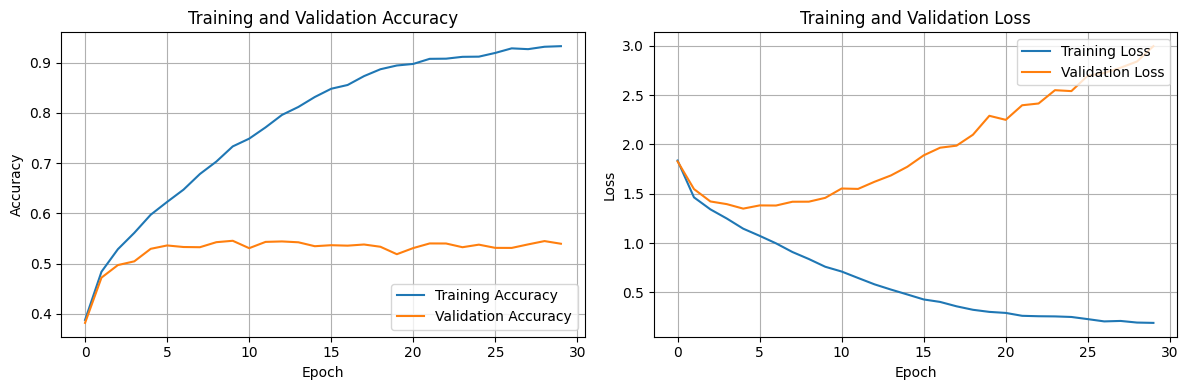

In [20]:
show_training_curves(history)

In [29]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(1024, activation='leaky_relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)), # Added L2 regularization
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(512, activation='leaky_relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)), # Added L2 regularization
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(256, activation='leaky_relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10)
])


model.compile(
    optimizer=tf.keras.optimizers.Adam(0.0001),  ## decreased learning rate
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

# Define EarlyStopping callback
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_sparse_categorical_accuracy',  # Monitor validation accuracy
    mode='max',             # Maximize validation accuracy
    patience=5,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True # Restore model weights from the epoch with the best value of the monitored quantity.
)

history = model.fit(
    ds_train,
    epochs=30,
    validation_data=ds_test,
    callbacks=[early_stopping_callback] # Add early stopping callback
)

Epoch 1/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 4.0848 - sparse_categorical_accuracy: 0.3381 - val_loss: 4.0379 - val_sparse_categorical_accuracy: 0.3916
Epoch 2/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 3.7697 - sparse_categorical_accuracy: 0.4158 - val_loss: 3.7571 - val_sparse_categorical_accuracy: 0.4565
Epoch 3/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 3.6004 - sparse_categorical_accuracy: 0.4543 - val_loss: 3.5288 - val_sparse_categorical_accuracy: 0.4846
Epoch 4/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 3.4721 - sparse_categorical_accuracy: 0.4745 - val_loss: 3.3809 - val_sparse_categorical_accuracy: 0.5008
Epoch 5/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 3.3495 - sparse_categorical_accuracy: 0.4873 - val_loss: 3.2753 - val_sparse_categorical_accuracy: 0.5085
Epoch 6/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 3.2328 - sparse_categorical_accuracy: 0.5061 - val_loss: 3.1669 - val_sparse_categorical_accuracy: 0.5178
Epoch 7/30

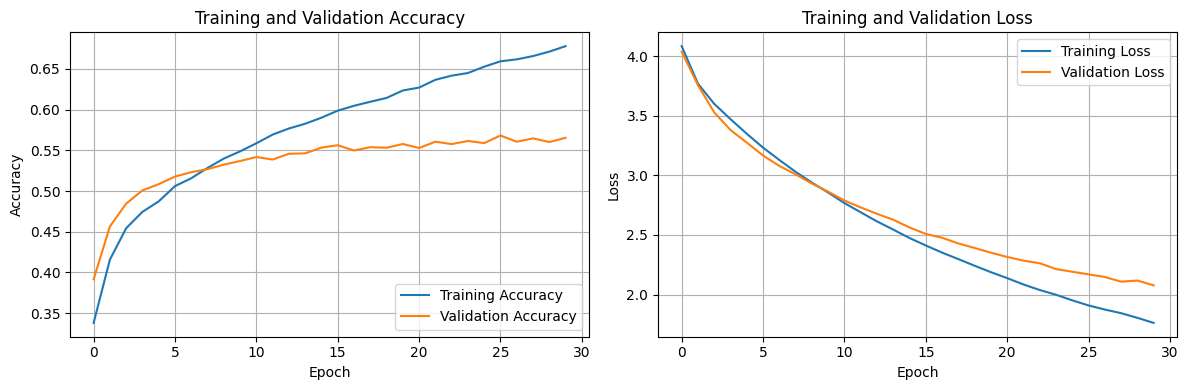

In [31]:
show_training_curves(history)

In [21]:
import tensorflow as tf

def augment_img(image, label):
  # Random horizontal flip
  image = tf.image.random_flip_left_right(image)
  # Random brightness adjustment
  image = tf.image.random_brightness(image, max_delta=0.2)
  # Random contrast adjustment
  image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
  # Random crop by padding and then cropping
  IMG_SIZE = 32
  paddings = tf.constant([[4, 4], [4, 4], [0, 0]]) # Pad by 4 pixels on each side (total 40x40)
  image = tf.pad(image, paddings, "REFLECT") # Use REFLECT padding to avoid black borders
  image = tf.image.random_crop(image, size=[IMG_SIZE, IMG_SIZE, 3])
  return image, label

# Re-build the training pipeline with data augmentation.
# Assumes 'ods_train', 'normalize_img', 'ds_info.splits['train'].num_examples', and 'tf.data.AUTOTUNE' are defined in prior cells.
ds_train = ods_train.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.cache()
# Apply data augmentation to the training dataset after caching normalized data
ds_train = ds_train.map(
    augment_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(512)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

print("Training dataset pipeline rebuilt with data augmentation.")
print("The new pipeline includes random horizontal flips, brightness, contrast adjustments, and random cropping.")

Training dataset pipeline rebuilt with data augmentation.
The new pipeline includes random horizontal flips, brightness, contrast adjustments, and random cropping.


### Early stopping and learning-rate tuning
Early stopping halts training when validation accuracy stops improving, which prevents overfitting and saves time. The lower learning rate here ($10^{-4}$) makes updates smaller and can improve stability.

### Checkpoints (recommended)
Use `ModelCheckpoint` to save the best model during training. Add it to the `callbacks` list alongside early stopping.

Example:
```python
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath='checkpoints/cifar10_ffn.keras',
    monitor='val_sparse_categorical_accuracy',
    save_best_only=True,
    mode='max'
 )
history = model.fit(..., callbacks=[early_stopping_callback, checkpoint_cb])
```

In [22]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(1024, activation='leaky_relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(512, activation='leaky_relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(256, activation='leaky_relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10)
])


model.compile(
    optimizer=tf.keras.optimizers.Adam(0.0001),  ## decreased learning rate
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

# Define EarlyStopping callback
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',  # Monitor validation accuracy
    mode='max',             # Maximize validation accuracy
    patience=5,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True # Restore model weights from the epoch with the best value of the monitored quantity.
)

history = model.fit(
    ds_train,
    epochs=30,
    validation_data=ds_test,
    callbacks=[early_stopping_callback] # Add early stopping callback
)

Epoch 1/30


98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 2.0413 - sparse_categorical_accuracy: 0.2777 - val_loss: 1.9346 - val_sparse_categorical_accuracy: 0.3943
Epoch 2/30


/Users/pewhite/miniconda3/envs/tfmetal-pip/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:99: UserWarning: Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: loss,sparse_categorical_accuracy,val_loss,val_sparse_categorical_accuracy
  current = self.get_monitor_value(logs)


98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 1.8538 - sparse_categorical_accuracy: 0.3404 - val_loss: 1.7533 - val_sparse_categorical_accuracy: 0.4360
Epoch 3/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 1.7898 - sparse_categorical_accuracy: 0.3615 - val_loss: 1.6311 - val_sparse_categorical_accuracy: 0.4488
Epoch 4/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 1.7541 - sparse_categorical_accuracy: 0.3767 - val_loss: 1.5691 - val_sparse_categorical_accuracy: 0.4642
Epoch 5/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 1.7224 - sparse_categorical_accuracy: 0.3870 - val_loss: 1.5274 - val_sparse_categorical_accuracy: 0.4668
Epoch 6/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 1.6952 - sparse_categorical_accuracy: 0.3953 - val_loss: 1.5039 - val_sparse_categorical_accuracy: 0.4788
Epoch 7/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 1.6701 - sparse_categorical_accuracy: 0.4050 - val_loss: 1.4847 - val_sparse_categorical_accuracy: 0.4855
Epoch 8/30
98/98 ━━━━

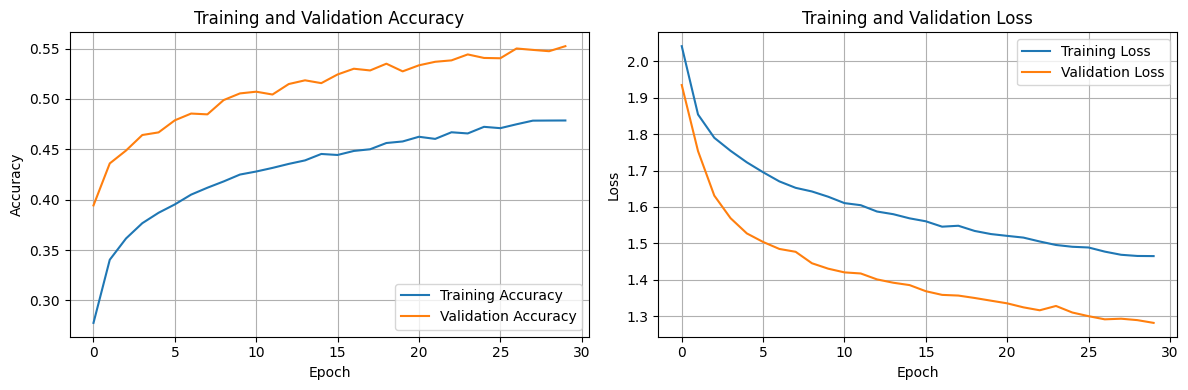

In [23]:
show_training_curves(history)

### Data augmentation
Augmentation makes the model more robust by creating varied training examples. We apply flips, brightness/contrast changes, and random crops **after** caching normalized images.

After rebuilding the pipeline, recompile and retrain the model so it learns from the augmented data. Compare the new learning curves to the earlier baseline.

In [ ]:
more_history = model.fit(
    ds_train,
    epochs=30,
    validation_data=ds_test,
    callbacks=[early_stopping_callback] # Add early stopping callback
)

Epoch 1/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 1.4510 - sparse_categorical_accuracy: 0.4847 - val_loss: 1.2735 - val_sparse_categorical_accuracy: 0.5549
Epoch 2/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 1.4550 - sparse_categorical_accuracy: 0.4809 - val_loss: 1.2747 - val_sparse_categorical_accuracy: 0.5552
Epoch 3/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 1.4505 - sparse_categorical_accuracy: 0.4821 - val_loss: 1.2623 - val_sparse_categorical_accuracy: 0.5568
Epoch 4/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 1.4475 - sparse_categorical_accuracy: 0.4834 - val_loss: 1.2624 - val_sparse_categorical_accuracy: 0.5553
Epoch 5/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 1.4399 - sparse_categorical_accuracy: 0.4895 - val_loss: 1.2589 - val_sparse_categorical_accuracy: 0.5536
Epoch 6/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 1.4386 - sparse_categorical_accuracy: 0.4865 - val_loss: 1.2503 - val_sparse_categorical_accuracy: 0.5612
Epoch 7/30

In [25]:

for key in more_history.history:
    history.history[key].extend(more_history.history[key])

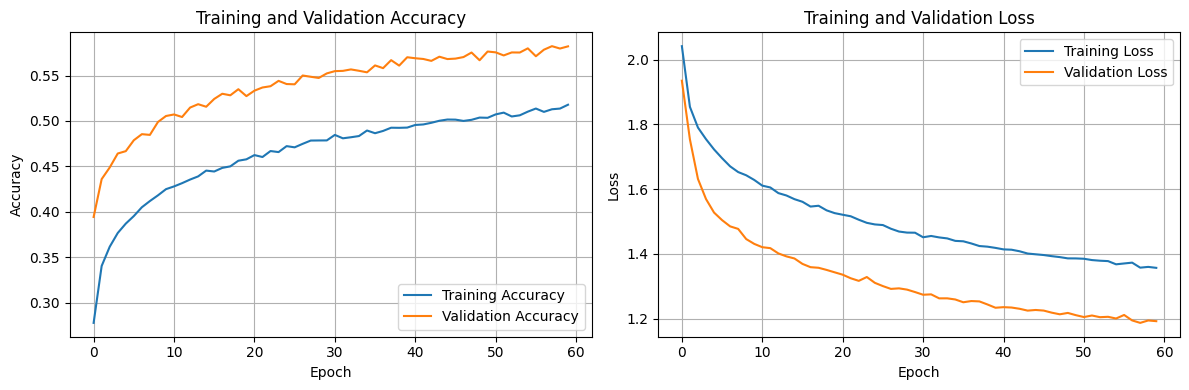

In [26]:
show_training_curves(history)

In [27]:
more_history = model.fit(
    ds_train,
    epochs=100,
    validation_data=ds_test,
    callbacks=[early_stopping_callback] # Add early stopping callback
)

Epoch 1/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 1.3538 - sparse_categorical_accuracy: 0.5161 - val_loss: 1.1917 - val_sparse_categorical_accuracy: 0.5815
Epoch 2/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 1.3493 - sparse_categorical_accuracy: 0.5191 - val_loss: 1.1861 - val_sparse_categorical_accuracy: 0.5770
Epoch 3/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 1.3509 - sparse_categorical_accuracy: 0.5161 - val_loss: 1.1770 - val_sparse_categorical_accuracy: 0.5839
Epoch 4/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 1.3486 - sparse_categorical_accuracy: 0.5155 - val_loss: 1.1826 - val_sparse_categorical_accuracy: 0.5872
Epoch 5/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 1.3482 - sparse_categorical_accuracy: 0.5178 - val_loss: 1.1795 - val_sparse_categorical_accuracy: 0.5823
Epoch 6/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 1.3439 - sparse_categorical_accuracy: 0.5205 - val_loss: 1.1790 - val_sparse_categorical_accuracy: 0.5860
Epoc

In [28]:
for key in more_history.history:
    history.history[key].extend(more_history.history[key])

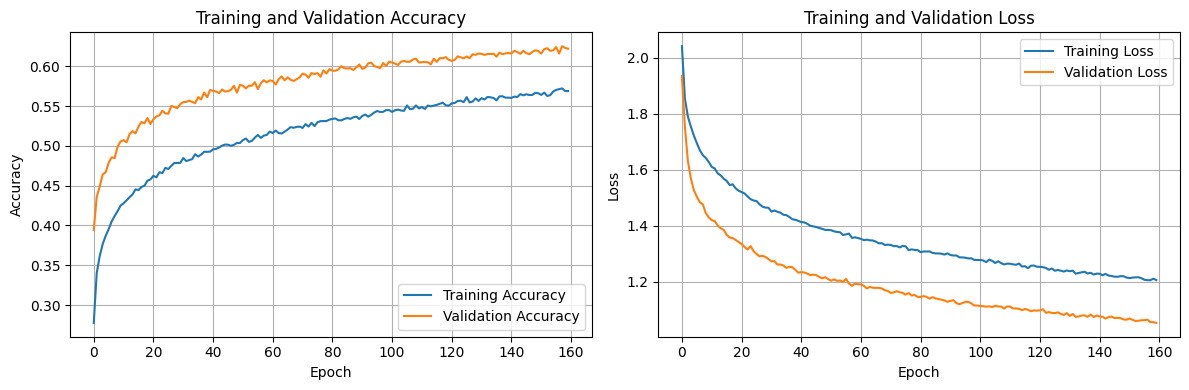

In [29]:
show_training_curves(history)